In [67]:
# ロバストなガウス過程回帰以下で使用
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles, make_classification

In [2]:
# ガウス過程識別モデル以下で使用
import GPy # documentation: https://gpy.readthedocs.io/en/deploy/

## ガウス過程回帰の一般化

### ロバストなガウス過程回帰

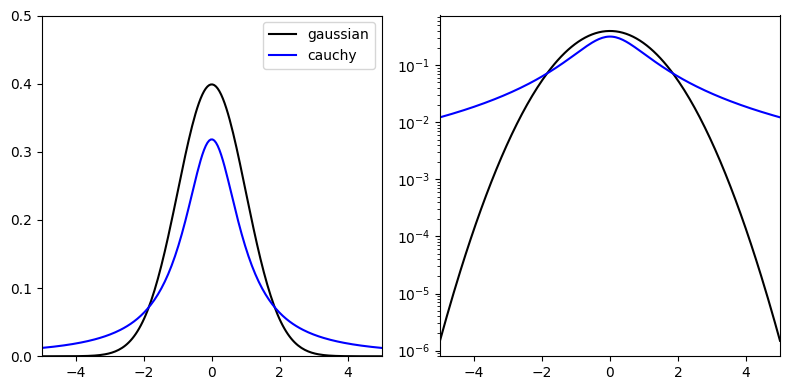

In [ ]:
# \gamma = 1 のcauchy分布
xx = np.linspace(-5, 5, 200)
yy_cauchy = 1/(np.pi*(1.0+(xx**2))) # 中心0、\gamma=1 のcauchy分布
yy_gauss = 1/np.sqrt(2*np.pi)*np.exp(-(xx**2)/2) #標準正規分布

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(xx, yy_gauss, color="black", label="gaussian")
ax[0].plot(xx, yy_cauchy, color="blue", label="cauchy")
ax[1].plot(xx, yy_gauss, color="black", label="gaussian")
ax[1].plot(xx, yy_cauchy, color="blue", label="cauchy")
ax[0].set_xlim(-5,5)
ax[0].set_ylim(0,0.5)
ax[0].legend()
ax[1].set_xlim(-5,5)
ax[1].set_yscale("log")
fig.tight_layout()

In [ ]:
# 楕円スライスサンプリングの実装 (http://chasen.org/~daiti-m/gpbook/python/elliptical.py)
# 入力: N(0, K) に従う現在のガウス過程 f (prior) と尤度関数 L (likfun)
# 出力: 新しくサンプルされた f (posterior)

#  xx     : Dx1 initial vector
#  prior  : DxD matrix from chol(L)
#  likfun : function of likelihood evaluation
#  params : parameters passed to likfun (optional)
#  curlik : current likelihood (possibly from previous iteration)
#  angle  : default 0 ((0,2*pi])

def elliptical(xx, prior, likfun, params, curlik = None, angle_range=0):
    rng = np.random.default_rng()
    D = len(xx)
    if curlik is None: # 現在の尤度の計算
        curlik = likfun(xx, params)
    nu = prior @ rng.normal(size=(1, D)).T # nuのサンプリング
    hh = np.log(rng.random()) + curlik # 尤度の閾値
    if angle_range <= 0:
        phi = rng.random()*2*np.pi # phiを一様分布からサンプリング
        min_phi = phi - 2*np.pi
        max_phi = phi
    else: # 現在の点を中心にランダムに探索区間を設定
        min_phi = - angle_range*rng.random()
        max_phi = min_phi + angle_range
        phi = min_phi + rng.random()*(max_phi - min_phi) # phiを一様分布からサンプリング
    while True:
        prop = xx*np.cos(phi) + nu*np.sin(phi)
        curlik = likfun(prop, params)
        if curlik > hh: # 尤度が閾値を超える(スライスより上にある)場合、prop を受理
            break
        else:
            if phi > 0:
                max_phi = phi
            elif phi < 0:
                min_phi = phi
            else:
                raise IOError('BUG: slice sampling shrunk to the current position.')
        phi = min_phi + rng.random()*(max_phi-min_phi) # phiを一様分布からサンプル
    return prop, curlik

In [157]:
class MyGPR_cauchy:
    def __init__(self, xtrain, ytrain, xx, kernel: str, params_gauss: list = None, gamma=1.0, iters=10) -> None:
        self.xtrain = xtrain
        self.len_xt = len(self.xtrain)
        self.ytrain = ytrain
        self.xx = xx
        self.xx_all = np.vstack([self.xtrain, self.xx])
        self.len_xx_all = len(self.xx_all)
        self.kernel_name = kernel
        self.params_gauss = params_gauss
        self.gamma = gamma
        self.iters = iters
        self.g_list = []
        if self.kernel_name == 'rbf':
            self.kernel_func = self.kgauss()

    def kgauss(self):
        if self.params_gauss is None:
            tau, sigma = 0.0, 0.0
        else:
            tau, sigma = self.params_gauss
        return lambda x1, x2: np.exp(tau) * np.exp(- np.sum((x1 - x2) ** 2, axis=0) / np.exp(sigma))
    
    def kernel_matrix(self, xx, epsilon=1e-6):
        n = xx.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = self.kernel_func(xx[i], xx[j])
        K_stable = K + epsilon * np.eye(K.shape[0])
        return K_stable
    
    def gpr_cauchy(self, f, K_inv):
        return self.gpr_cauchy_lik(f[:self.len_xt], K_inv)
    
    def gpr_cauchy_lik(self, f, K_inv):
        sumlik_cauchy = 0
        for i in range(self.len_xt):
            sumlik_cauchy += - np.log(self.gamma + (self.ytrain[i,0]-f[i,0])**2/self.gamma)
        return sumlik_cauchy - (f.T @ K_inv @ f)[0,0]
    
    def gpr_mcmc(self):
        rng = np.random.default_rng()
        K = self.kernel_matrix(self.xx_all)
        K_inv = np.linalg.inv(K[:self.len_xt, :self.len_xt])
        L = np.linalg.cholesky(K)
        f = L @ rng.normal(size=(1, self.len_xx_all)).T
        # g = np.zeros(self.len_xx_all)
        for i in range(self.iters):
            f, lik = self.elliptical(f, L, K_inv)
            # g = g + f.T[0]
            # self.g_list.append(g)
            self.g_list.append(f.T[0])
            if (i+1) % 10 == 0:
                print(f'[iter {i+1}]')
        return None
    
    def plot_gpr_mcmc(self):
        g_sum = np.zeros(self.len_xx_all - self.len_xt)
        colors = plt.cm.rainbow(np.linspace(0, 1, self.iters))
        fig, ax = plt.subplots()
        g_sum = np.zeros(self.len_xx_all - self.len_xt)
        for i in range(self.iters):
            ax.plot(self.xx, self.g_list[i][self.len_xt:], color=colors[i], linewidth = 1, zorder=0)
            g_sum += self.g_list[i][self.len_xt:]
        ax.plot(self.xx, g_sum/self.iters, color='black', linewidth = 3, zorder=1)
        ax.scatter(self.xtrain, self.ytrain, marker='x', color='black', label='Train', zorder=2)

    def elliptical(self, f, prior, K_inv, curlik = None, angle_range=0):
        rng = np.random.default_rng()
        if curlik is None: # 現在の尤度の計算
            curlik = self.gpr_cauchy(f, K_inv)
        nu = prior @ rng.normal(size=(1, self.len_xx_all)).T # nuのサンプリング
        hh = np.log(rng.random()) + curlik # 尤度の閾値
        if angle_range <= 0:
            phi = rng.random()*2*np.pi # phiを一様分布からサンプリング
            min_phi = phi - 2*np.pi
            max_phi = phi
        else: # 現在の点を中心にランダムに探索区間を設定
            min_phi = - angle_range*rng.random()
            max_phi = min_phi + angle_range
            phi = min_phi + rng.random()*(max_phi - min_phi) # phiを一様分布からサンプリング
        while True:
            prop = f*np.cos(phi) + nu*np.sin(phi)
            curlik = self.gpr_cauchy(prop, K_inv)
            if curlik > hh: # 尤度が閾値を超える(スライスより上にある)場合、prop を受理
                break
            else:
                if phi > 0:
                    max_phi = phi
                elif phi < 0:
                    min_phi = phi
                else:
                    raise IOError('BUG: slice sampling shrunk to the current position.')
            phi = min_phi + rng.random()*(max_phi-min_phi) # phiを一様分布からサンプル
        return prop, curlik
    

In [158]:
data = np.loadtxt('./../data/chap3/gpr-cauchy.dat')
xtrain, ytrain = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
xx = np.linspace(-5, 5, 100).reshape(-1, 1)

[iter 10]
[iter 20]
[iter 30]
[iter 40]
[iter 50]
[iter 60]
[iter 70]
[iter 80]
[iter 90]
[iter 100]


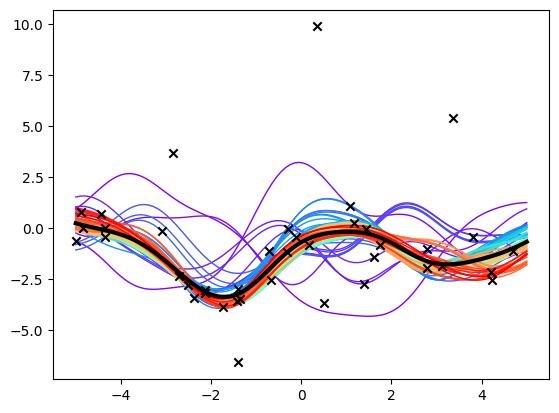

In [159]:
params_gauss = np.array([1.0, 1.0])
gamma = 0.2
gpr_cauchy = MyGPR_cauchy(xtrain, ytrain, xx, "rbf", params_gauss, gamma, iters=100)
gpr_cauchy.gpr_mcmc()
gpr_cauchy.plot_gpr_mcmc()

### ガウス過程識別モデル

In [44]:
# 標準正規分布の累積密度関数とシグモイド関数

# def gaussian(x: np.ndarray) -> np.ndarray:
#     return 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)

# n_points = 200000
# x_min = -100
# x_max = 100
# xx = np.linspace(x_min, x_max, n_points)
# yy_cdf = np.cumsum(gaussian(xx)/n_points*(x_max-x_min))
# yy_sigmoid = 1/(1 + np.exp(-1.7*xx))

# fig, ax = plt.subplots(1,2, figsize=(8,2))
# ax[0].plot(xx, yy_cdf, color="black", label="probit")
# ax[0].plot(xx, yy_sigmoid, color="blue", label="sigmoid")
# ax[1].plot(xx, yy_cdf-yy_sigmoid, color="blue")
# ax[1].plot([-5,5], [0.01,0.01], "--",color="black", linewidth=1)
# ax[1].plot([-5,5], [-0.01,-0.01], "--",color="black", linewidth=1)
# # ax[1].plot([-5,5], [0,0], "--",color="black", linewidth=1)
# ax[0].set_xlim(-5,5)
# ax[0].set_ylim(0,1)
# ax[0].legend()
# ax[1].set_xlim(-5,5)
# ax[1].set_ylim(-0.02,0.02)
# fig.tight_layout()

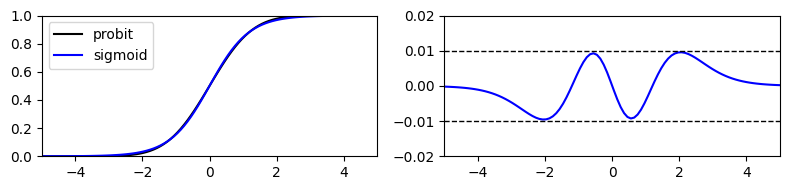

In [ ]:
# 標準正規分布の累積密度関数とシグモイド関数

xx = np.linspace(-5, 5, 100)
yy_cdf = norm.cdf(xx)
yy_sigmoid = 1/(1 + np.exp(-1.7*xx))

fig, ax = plt.subplots(1,2, figsize=(8,2))
ax[0].plot(xx, yy_cdf, color="black", label="probit")
ax[0].plot(xx, yy_sigmoid, color="blue", label="sigmoid")
ax[1].plot(xx, yy_cdf-yy_sigmoid, color="blue")
ax[1].plot([-5,5], [0.01,0.01], "--",color="black", linewidth=1)
ax[1].plot([-5,5], [-0.01,-0.01], "--",color="black", linewidth=1)
# ax[1].plot([-5,5], [0,0], "--",color="black", linewidth=1)
ax[0].set_xlim(-5,5)
ax[0].set_ylim(0,1)
ax[0].legend()
ax[1].set_xlim(-5,5)
ax[1].set_ylim(-0.02,0.02)
fig.tight_layout()

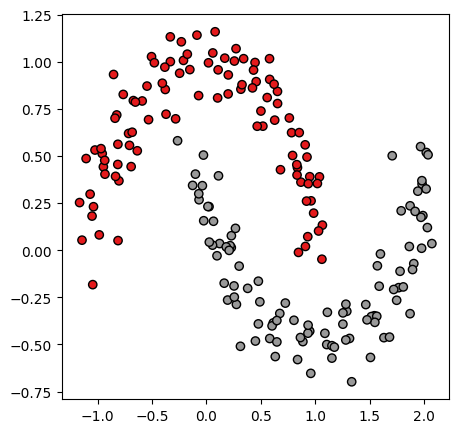

In [ ]:
X1, y1 = make_moons(n_samples=200, noise=0.1, random_state=0)
plt.figure(figsize=(5,5))
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.cm.Set1, edgecolor='k')
plt.show()

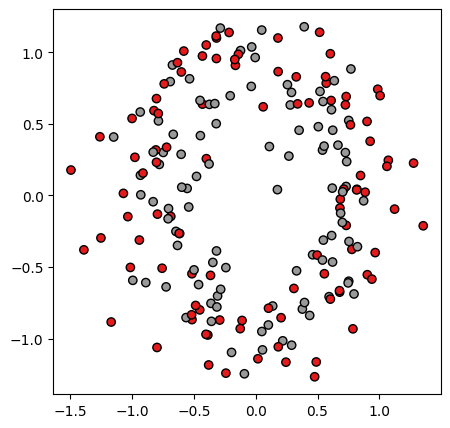

In [153]:
X2, y2 = make_circles(n_samples=200, noise=0.2, random_state=0)
plt.figure(figsize=(5,5))
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.cm.Set1, edgecolor='k')
plt.show()

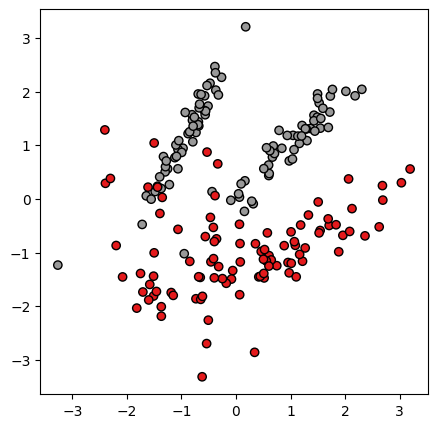

In [140]:
X3, y3 = make_classification(n_samples=200, n_features=2, n_redundant=0,
                           n_informative=2, n_clusters_per_class=2,
                           random_state=4)

plt.figure(figsize=(5,5))
plt.scatter(X3[:,0], X3[:,1], c=y3, cmap=plt.cm.Set1, edgecolor='k')
plt.show()

In [154]:
model = GPy.models.GPClassification(
    X=X2,
    Y=y2.reshape(-1,1),
    kernel=GPy.kern.RBF(input_dim=2, variance=1.0),
    # likelihood=GPy.likelihoods.Bernoulli(), # デフォルト値
    # inference_method=GPy.inference.latent_function_inference.EP() # デフォルト値
)

# 次のようにも書ける
# model = GPy.core.GP(
#     X=X2,
#     Y=y2.reshape(-1,1),
#     kernel=GPy.kern.RBF(input_dim=2, variance=1.0),
#     likelihood=GPy.likelihoods.Bernoulli(),
#     inference_method=GPy.inference.latent_function_inference.EP()
# )

model.optimize(messages=True)
print(model)


Name : gp_classification
Objective : 134.85169936954458
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  1.4114071170981428  |      +ve      |        
  rbf.lengthscale     |  0.9259838057315175  |      +ve      |        


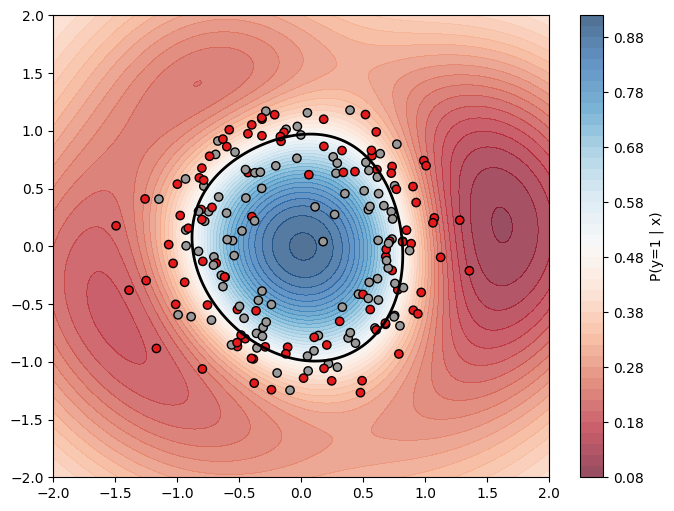

In [155]:
# 分類の描画
xx, yy = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

# 潜在関数の予測
mu, var = model.predict(Xgrid)
probs = mu.reshape(xx.shape)

plt.figure(figsize=(8, 6))

contour = plt.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.7)
plt.colorbar(contour, label="P(y=1 | x)")
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.cm.Set1, edgecolor='k')

# 決定境界 (確率=0.5)
plt.contour(xx, yy, probs, levels=[0.5], colors="k", linewidths=2)
plt.show()

### ポアソン回帰モデル

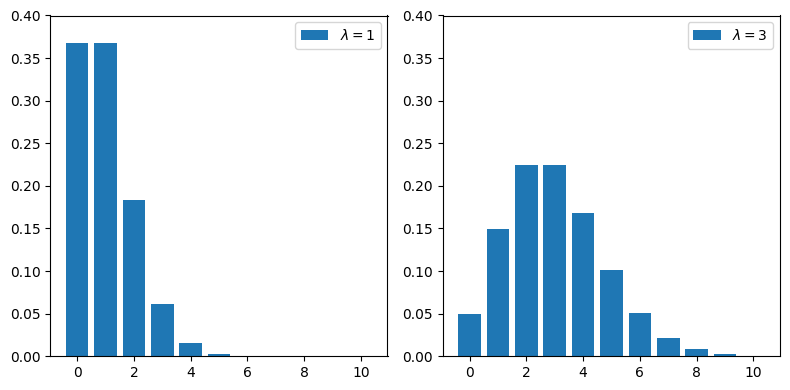

In [202]:
# ポアソン分布
def poisson(xx, lamb):
    return np.array([lamb**x*np.exp(-lamb)/(math.factorial(x)) for x in xx])

xx = np.arange(0, 11, 1)
yy_p1 = poisson(xx, 1)
yy_p3 = poisson(xx, 3)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].bar(xx, yy_p1, label="$\\lambda = 1$")
ax[1].bar(xx, yy_p3, label="$\\lambda = 3$")
ax[0].set_ylim(0,0.4)
ax[0].legend()
ax[1].set_ylim(0,0.4)
ax[1].legend()
fig.tight_layout()

In [156]:
# 学習データの読み込み
y_train = np.loadtxt("./../data/chap3/kubo.dat", dtype=int).reshape(-1, 1)
x_train = np.arange(1, len(y_train)+1, 1).reshape(-1, 1)

In [157]:
model = GPy.core.GP(
    X=x_train,
    Y=y_train,
    kernel=GPy.kern.RBF(1),
    likelihood=GPy.likelihoods.Poisson(),
    inference_method=GPy.inference.latent_function_inference.Laplace()
)
model.optimize(messages=True)
print(model)


Name : gp
Objective : 139.11576469148858
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |               value  |  constraints  |  priors
  rbf.variance     |   4.732895218606783  |      +ve      |        
  rbf.lengthscale  |  14.853345451744085  |      +ve      |        


mean: [[ 2.60468448  3.34568055  4.2637588   5.36779105  6.65042818  8.0833785
   9.61555518 11.17554155 12.67881169 14.03869751 15.17877089 16.04370407
  16.60607994 16.86787687 16.8569079  16.61974196 16.21319114 15.6962858
  15.12402237 14.5433975  13.99160457 13.49588935 13.07443827 12.73772731
  12.48990436 12.32994068 12.25243135 12.2480364  12.30363705 12.40234287
  12.52352968 12.64311314 12.73425894 12.76868401 12.71860399 12.55923205
  12.27155696 11.84496643 11.27919565 10.58511748  9.78407126  8.9057195
   7.98475045  7.05700824  6.15574778  5.30864361  4.53596024  3.84999687
   3.25564469  2.75171511]]


{'dataplot': [<matplotlib.collections.PathCollection at 0x315910e30>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x31595e810>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x31595dd30>]}

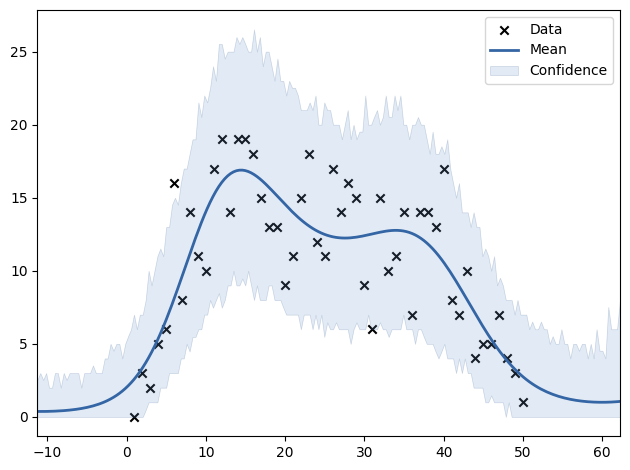

In [159]:
mu, var = model.predict(x_train)
print(f'mean: {mu.T}')
# print(f'varience: {var.T}')
model.plot()